<a href="https://colab.research.google.com/github/yuminliu/KaggleHousePrices/blob/master/HousePrice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
import copy
%matplotlib inline

read in data

In [0]:
#%% read in data
#### if run in local
#train = pd.read_csv('../data/train.csv')
#test = pd.read_csv('../data/test.csv')

train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

#### if run from google drive
# from google.colab import drive
# drive.mount('/content/gdrive')

# train_filename = '/content/gdrive/My Drive/Colab Notebooks/PingAnDataChallenge/data/train.csv'
# test_filename = '/content/gdrive/My Drive/Colab Notebooks/PingAnDataChallenge/data/test.csv'
# train = pd.read_csv(train_filename)
# test = pd.read_csv(test_filename)

separate id

In [0]:
train_id = train['Id']
train = train.drop(['Id'],axis=1)
test_id = test['Id']
test = test.drop(['Id'],axis=1)
test['SalePrice'] = 0

remove outliers of continuous features in training data, first get the continuous features

In [0]:
continuous = list(['LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',\
                   'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',\
                   'GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch',\
                   'ScreenPorch','MiscVal','SalePrice'])

plot the continuous features and fit a regression the them, and then visually find out the outliers

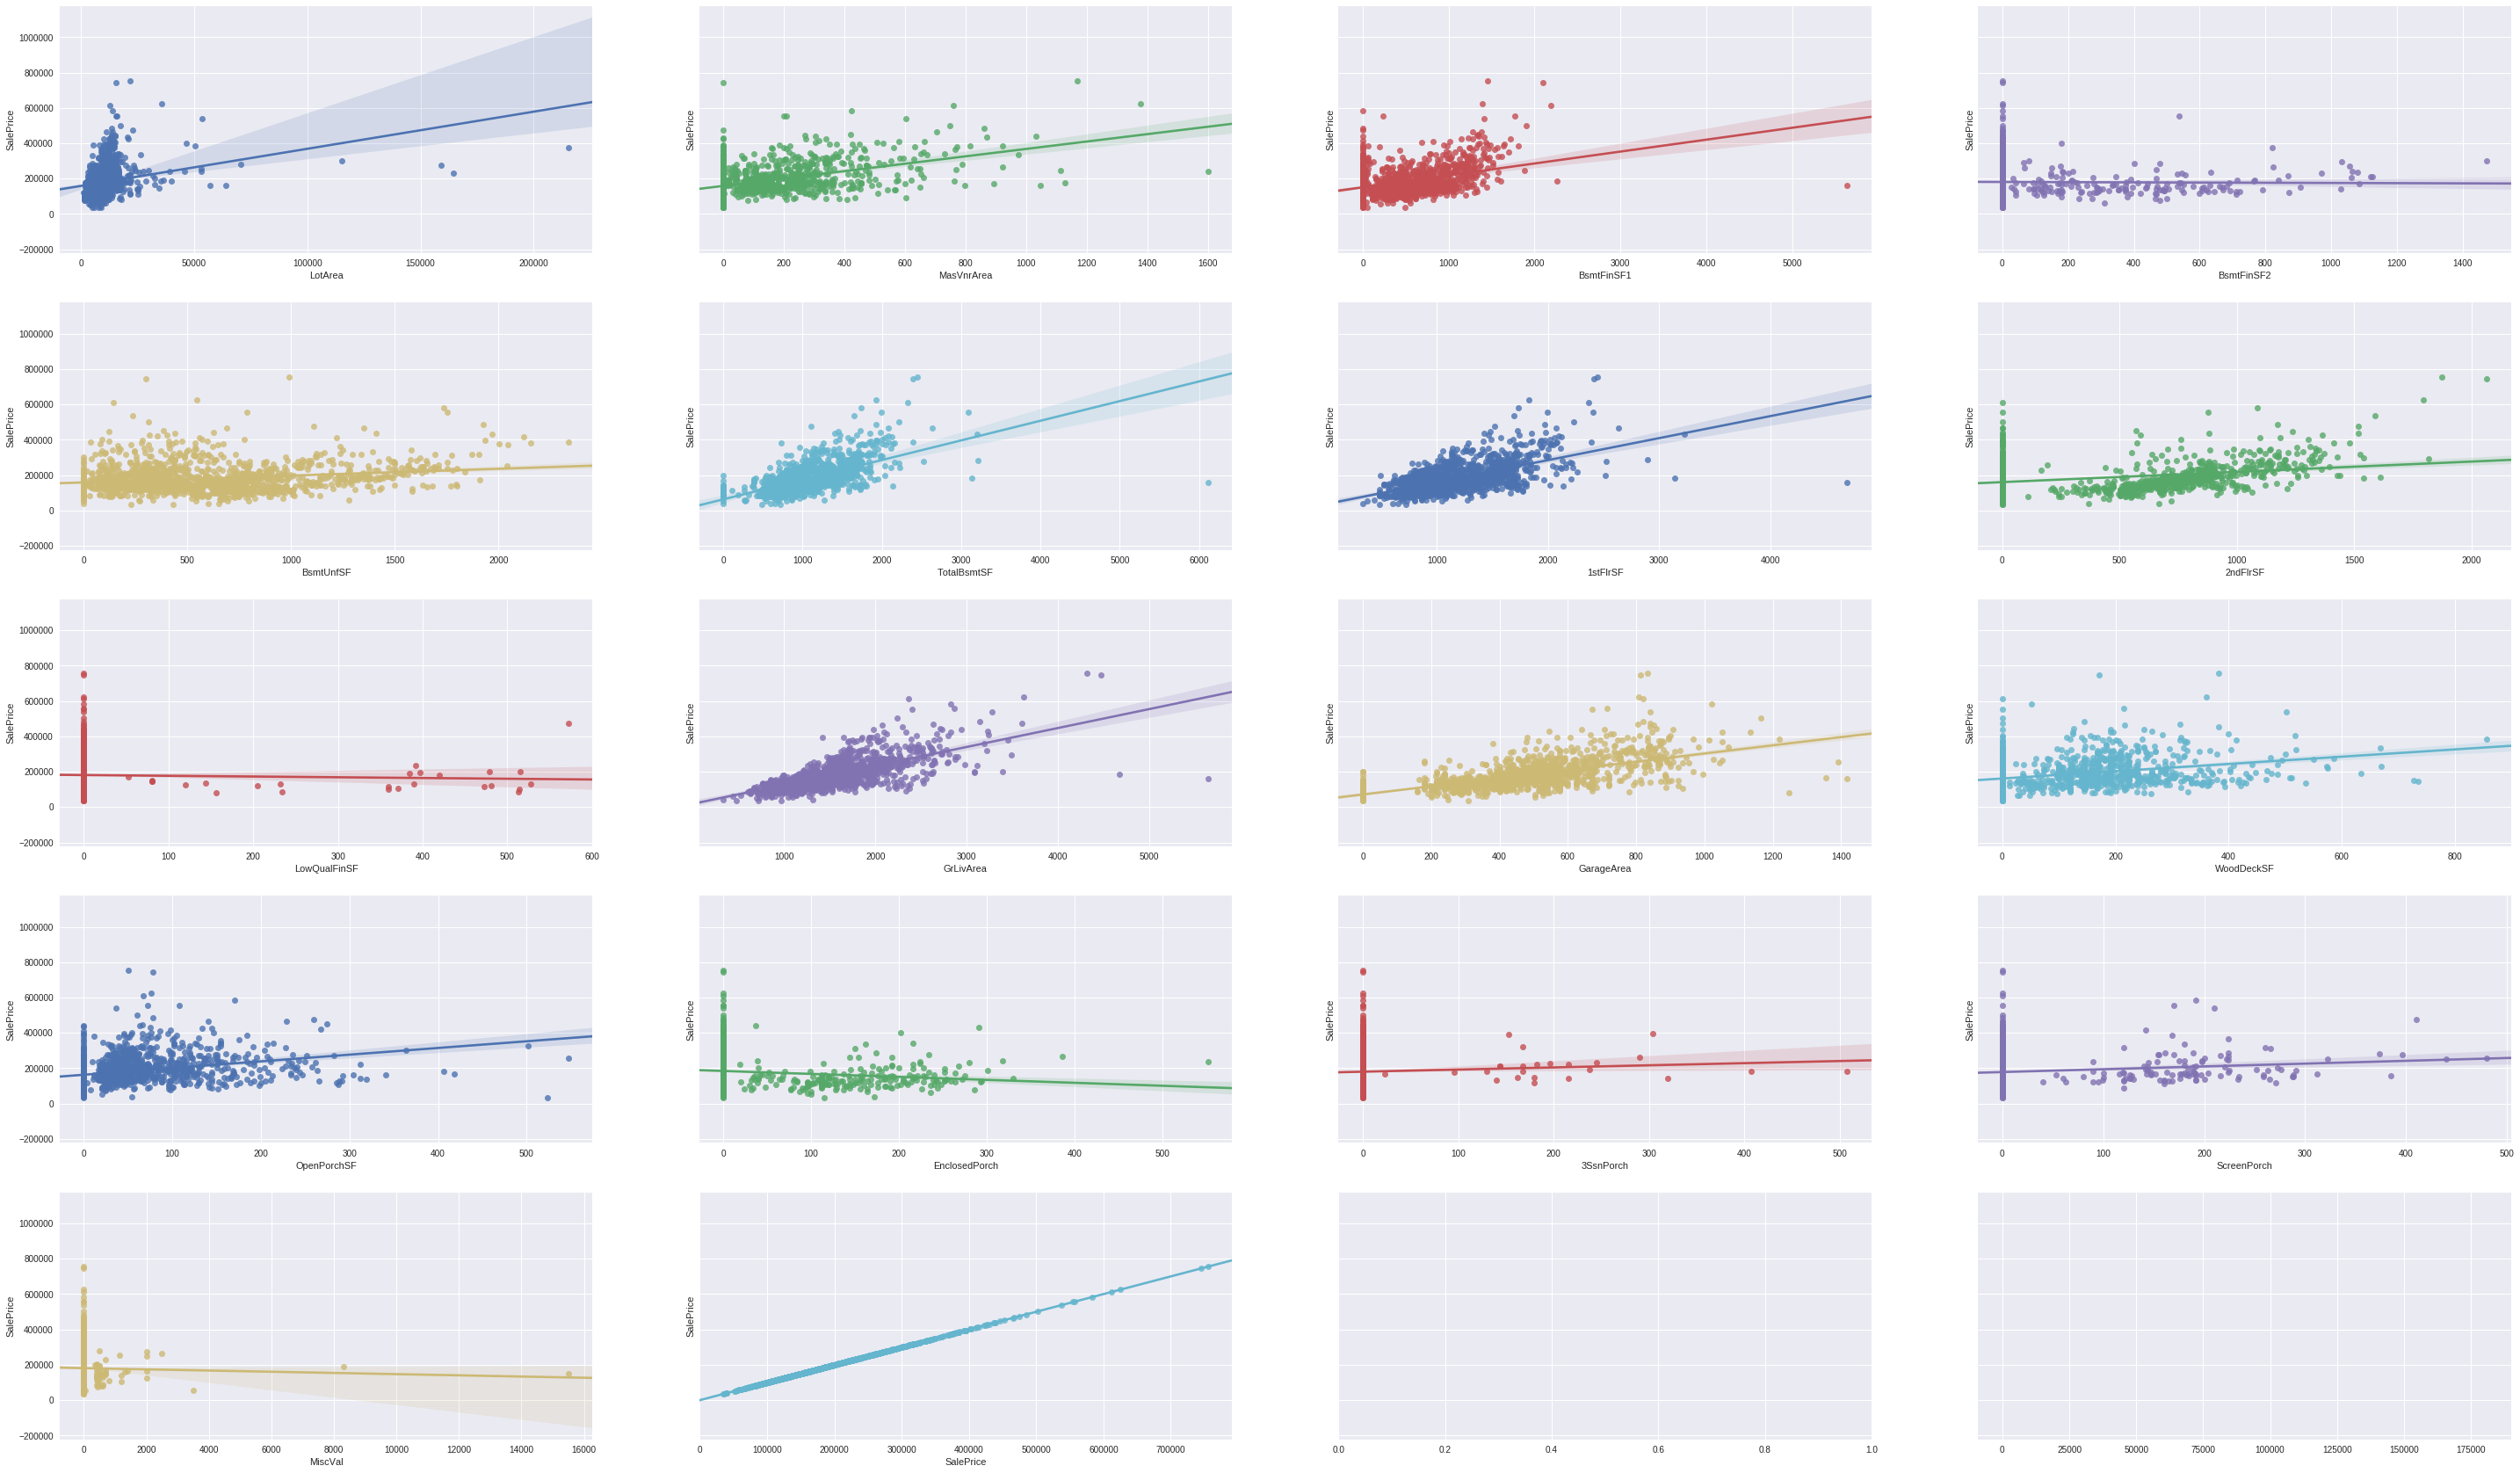

In [5]:
ncols = 4
nrows = int(np.ceil(len(continuous)/ncols))
fig, axs = plt.subplots(ncols=ncols,nrows=nrows,figsize=(50,30),sharey=True)
for i in range(nrows):
   for j in range(ncols):
       ind = i*ncols+j
       if(ind>=len(continuous)):
           break
       var = continuous[i*ncols+j]
       sns.regplot(x=var, y='SalePrice', data=train, ax=axs[i][j])

now remove the outliers in the training data

In [0]:
#train = train.drop(train[(train['GrLivArea']>4000)].index)
train = train.drop(train.loc[train['LotArea']>100000].index,axis=0)
train = train.drop(train.loc[train['BsmtFinSF1']>2000].index,axis=0)
train = train.drop(train.loc[train['TotalBsmtSF']>4000].index,axis=0)
train = train.drop(train.loc[train['1stFlrSF']>3000].index,axis=0)
train = train.drop(train.loc[train['GrLivArea']>4500].index,axis=0)
train = train.drop(train.loc[train['MiscVal']>3000].index,axis=0)
train = train.drop(train.loc[train['EnclosedPorch']>400].index,axis=0)
train = train.drop(train.loc[train['GarageArea']>1200].index,axis=0)
#train = train.drop(train.loc[train['MasVnrArea']>1400].index,axis=0)
#train = train.drop(train.loc[train['WoodDeckSF']>700].index,axis=0)
train_num = len(train)

In [7]:
pd.__version__

'0.22.0'

fill in missing data according to different type

in all the cases the values in 'Utilities' are 'AllPub' except for 3 cases, thus it will not be helpful for prediction and it's safe to remove. NA in those nanisnone categorical values means absence of the features, thus they are filled with 'None'. NA in those naniszero numerical values means absence of the features, thus they are filled with 0

In [0]:
vartodelete = list(['Utilities'])
nanisnone = list(['GarageCond','GarageFinish','GarageQual','GarageType','BsmtCond',\
                'BsmtExposure','BsmtQual','BsmtFinType2','BsmtFinType1',\
                'MasVnrType','PoolQC','MiscFeature','Alley',\
                'Fence','FireplaceQu'])
naniszero = list(['MasVnrArea','GarageCars','GarageArea','BsmtFinSF1',\
                  'BsmtFullBath','BsmtHalfBath','TotalBsmtSF','BsmtUnfSF',\
                  'BsmtFinSF2'])
for var in vartodelete:
    train = train.drop(var,axis=1)
    test = test.drop(var,axis=1)
for var in nanisnone: 
    train[var] = train[var].fillna('None')
    test[var] = test[var].fillna('None')
for var in naniszero:
    train[var] = train[var].fillna(0)
    test[var] = test[var].fillna(0)

delete missing instances in training data. we may want to delete missing data in training data. This will have pros and cons. In one hand, removing them will give more "clean" data for training thus maybe benificial; in the other hand, removing them will resulting less data for training thus maybe harmful

In [0]:
for var in list(train.columns.values):
   train = train.drop(train.loc[train[var].isnull()].index,axis=0)
train_num = len(train)
#absnum_train = train.isnull().sum().sort_values(ascending=False)
#percent_train = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
#missing_train = pd.concat([absnum_train,percent_train],axis=1,keys=['AbsNum_train','Percent_train'])
#missing_train.head(60)   
#absnum_test = test.isnull().sum().sort_values(ascending=False)
#percent_test = (test.isnull().sum()/test.isnull().count()).sort_values(ascending=False)
#missing_test = pd.concat([absnum_test,percent_test],axis=1,keys=['AbsNum_test','Percent_test'])
#missing_test.head(20) 

NA in those categorical values means really no data, thus filled with most common values seem all over the same column

In [0]:
nanismode = list(['MSZoning','Functional','Exterior1st','Exterior2nd',\
                  'KitchenQual','SaleType','Electrical'])
for var in nanismode:
    train[var] = train[var].fillna(train[var].mode()[0])
    test[var] = test[var].fillna(train[var].mode()[0])

NA in those categorical values means really no data, thus filled with most common values seem all over the same column and maybe more accurate by filling with most common values in the same Neighbour

In [0]:
nanisothers = list(['LotFrontage','GarageYrBlt'])  
for var in nanisothers:
    train[var] = train.groupby("Neighborhood")[var].transform(lambda x: x.fillna(x.median()))
    #test[var] = test[var].fillna(train.groupby("Neighborhood")[var].median())
    test[var] = test[var].fillna(train[var].median())


tranform acutal categorical data or numerical data

In [0]:
#num2cat_var = list(['MSSubClass'])
#cat2num_var = list(['GarageYrBlt'])
num2cat_var = list(['MSSubClass','YrSold','MoSold'])
cat2num_var = list([])
for var in num2cat_var:
    train[var] = train[var].astype(str)
    test[var] = test[var].astype(str)
for var in cat2num_var:
    train[var] = train[var].astype(float)  
    test[var] = test[var].astype(float)

transform target y to log

In [0]:
train['SalePrice'] = np.log1p(train['SalePrice'])

concatenate training and testing data to to further preprocessing together

In [0]:
#data_all = pd.concat([train,test],axis=0,sort=False).reset_index(drop=True)
data_all = pd.concat([train,test],axis=0).reset_index(drop=True)

encode categorical data whose order may contain information

In [0]:
from sklearn.preprocessing import LabelEncoder
vartoencode = list(['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold'])
#vartoencode = list(['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
#        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
#        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
#        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir'])
lbe = LabelEncoder() 
for var in vartoencode:
    lbe.fit_transform(list(data_all[var].values))
    #lbe.fit(list(train[var].values)) 
    #train[var] = lbe.transform(list(train[var].values))
    #lbe.fit(list(test[var].values)) 
    #test[var] = lbe.transform(list(test[var].values))

get dummy variables for the categorical data

In [0]:
data_all = pd.get_dummies(data_all)

split training and testing data

In [0]:

train = data_all[:train_num]
test = data_all[train_num:]

train_y = train['SalePrice']
train_x = train.drop('SalePrice',axis=1)
test_y = test['SalePrice']
test_x = test.drop('SalePrice',axis=1)

transform dataframe into numpy arrays, this is for xgb

In [0]:
train_y = train_y.values
train_x = train_x.values
test_y = test_y.values
test_x = test_x.values

split training data into new training data and validation data

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(train_x, train_y, test_size=0.25, random_state=42)

fit to models

In [0]:
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV, ElasticNet
from sklearn.ensemble import RandomForestRegressor

def write_submission(y_test_pred,test_id=test_id,filename='submission.csv'):
    submission = pd.DataFrame()
    submission['Id'] = test_id
    submission['SalePrice'] = y_test_pred
    #submission.to_csv('../results/'+filename,index=False)
    submission.to_csv('./'+filename,index=False)

lasso regression

In [21]:
alpha = 5e-5   
lasso = Lasso(alpha=alpha,random_state=42)
lasso.fit(X_train, y_train)
y_train_pred_lasso = lasso.predict(X_train)
y_valid_pred_lasso = lasso.predict(X_valid)
y_test_pred_lasso = lasso.predict(test_x)
y_test_pred_lasso = np.exp(y_test_pred_lasso) - 1
train_rmse_lasso = np.sqrt(np.mean((y_train-y_train_pred_lasso)**2))
valid_rmse_lasso = np.sqrt(np.mean((y_valid-y_valid_pred_lasso)**2))
print("lasso train rmse is: {};\nvalidate rmse is: {}".format(train_rmse_lasso,valid_rmse_lasso))
write_submission(y_test_pred=y_test_pred_lasso,filename='lasso_submission.csv')

lasso train rmse is: 0.07798392173558757;
validate rmse is: 0.12246391525560345


lassoCV

In [22]:
alphas = [1e-5,5e-5,1e-4,5e-4,1e-3,5e-3,1e-2,1e-1,1.0,10.0]    
lassocv = LassoCV(alphas=alphas,random_state=42)
lassocv.fit(X_train, y_train)
print(lassocv.alpha_)
y_train_pred_lassocv = lassocv.predict(X_train)
y_valid_pred_lassocv = lassocv.predict(X_valid)
y_test_pred_lassocv = lassocv.predict(test_x)
y_test_pred_lassocv = np.exp(y_test_pred_lassocv) - 1
train_rmse_lassocv = np.sqrt(np.mean((y_train-y_train_pred_lassocv)**2))
valid_rmse_lassocv = np.sqrt(np.mean((y_valid-y_valid_pred_lassocv)**2))
print("lassocv train rmse is: {};\nvalidate rmse is: {}".format(train_rmse_lassocv,valid_rmse_lassocv))
write_submission(y_test_pred=y_test_pred_lassocv,filename='lassocv_submission.csv')

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.0005
lassocv train rmse is: 0.08877408044135891;
validate rmse is: 0.11119752999624133


ridge regression

In [23]:
alpha = 5e-5
ridge = Ridge(alpha=alpha,random_state=42)
ridge.fit(X_train, y_train)
y_train_pred_ridge = ridge.predict(X_train)
y_valid_pred_ridge = ridge.predict(X_valid)
y_test_pred_ridge = ridge.predict(test_x)
y_test_pred_ridge = np.exp(y_test_pred_ridge) - 1
train_rmse_ridge = np.sqrt(np.mean((y_train-y_train_pred_ridge)**2))
valid_rmse_ridge = np.sqrt(np.mean((y_valid-y_valid_pred_ridge)**2))
print("ridge train rmse is: {};\nvalidate rmse is: {}".format(train_rmse_ridge,valid_rmse_ridge))
write_submission(y_test_pred=y_test_pred_ridge,filename='ridge_submission.csv')

ridge train rmse is: 0.0767160907267035;
validate rmse is: 0.13344729385213644


ridgeCV

In [24]:
alphas = [1e-5,5e-5,1e-4,5e-4,1e-3,5e-3,1e-2,1e-1,1.0,10.0]    
ridgecv = RidgeCV(alphas=alphas)
ridgecv.fit(X_train, y_train)
print(ridgecv.alpha_)
y_train_pred_ridgecv = ridgecv.predict(X_train)
y_valid_pred_ridgecv = ridgecv.predict(X_valid)
y_test_pred_ridgecv = ridgecv.predict(test_x)
y_test_pred_ridgecv = np.exp(y_test_pred_ridgecv) - 1
train_rmse_ridgecv = np.sqrt(np.mean((y_train-y_train_pred_ridgecv)**2))
valid_rmse_ridgecv = np.sqrt(np.mean((y_valid-y_valid_pred_ridgecv)**2))
print("ridgecv train rmse is: {};\nvalidate rmse is: {}".format(train_rmse_ridgecv,valid_rmse_ridgecv))
write_submission(y_test_pred=y_test_pred_ridgecv,filename='ridgecv_submission.csv')

10.0
ridgecv train rmse is: 0.08522926015394963;
validate rmse is: 0.11723793591139657


ElasticNet

In [25]:
elsn = ElasticNet(alpha=0.0005, l1_ratio=0.9, random_state=42)
elsn.fit(X_train, y_train)
y_train_pred_elsn = elsn.predict(X_train)
y_valid_pred_elsn = elsn.predict(X_valid)
y_test_pred_elsn = elsn.predict(test_x)
y_test_pred_elsn = np.exp(y_test_pred_elsn) - 1
train_rmse_elsn = np.sqrt(np.mean((y_train-y_train_pred_elsn)**2))
valid_rmse_elsn = np.sqrt(np.mean((y_valid-y_valid_pred_elsn)**2))
print("elsn train rmse is: {};\nvalidate rmse is: {}".format(train_rmse_elsn,valid_rmse_elsn))
write_submission(y_test_pred=y_test_pred_elsn,filename='elsn_submission.csv')

elsn train rmse is: 0.08800094129221157;
validate rmse is: 0.11124805892650229


random forest regression

In [26]:
n_estimators = 500
randomforest = RandomForestRegressor(n_estimators=n_estimators,random_state=42)
randomforest.fit(X_train, y_train)
#print(-np.sort(-randomforest.feature_importances_)[:30])
#a = -np.sort(-randomforest.feature_importances_)
y_train_pred_randomforest = randomforest.predict(X_train)
y_valid_pred_randomforest = randomforest.predict(X_valid)
y_test_pred_randomforest = randomforest.predict(test_x)
y_test_pred_randomforest = np.exp(y_test_pred_randomforest) - 1
train_rmse_randomforest = np.sqrt(np.mean((y_train-y_train_pred_randomforest)**2))
valid_rmse_randomforest = np.sqrt(np.mean((y_valid-y_valid_pred_randomforest)**2))
print("randomforest train rmse is: {};\nvalidate rmse is: {}".format(train_rmse_randomforest,valid_rmse_randomforest))
write_submission(y_test_pred=y_test_pred_randomforest,filename='randomforest_submission.csv')

randomforest train rmse is: 0.05035300507262424;
validate rmse is: 0.13096940420888595


XGBoost regression

In [27]:
import xgboost# as xgb
xgb = xgboost.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1, nthread = -1,random_state=42)
xgb.fit(X_train,y_train)
y_train_pred_xgb = xgb.predict(X_train)
y_valid_pred_xgb = xgb.predict(X_valid)
y_test_pred_xgb = xgb.predict(test_x)
y_test_pred_xgb = np.exp(y_test_pred_xgb) - 1
train_rmse_xgb = np.sqrt(np.mean((y_train-y_train_pred_xgb)**2))
valid_rmse_xgb = np.sqrt(np.mean((y_valid-y_valid_pred_xgb)**2))
print("xgb train rmse is: {};\nvalidate rmse is: {}".format(train_rmse_xgb,valid_rmse_xgb))
write_submission(y_test_pred=y_test_pred_xgb,filename='xgb_submission.csv')

xgb train rmse is: 0.08072395057021652;
validate rmse is: 0.10842219171747469


ensemble method by simply averaging the results from models above

In [28]:
y_train_pred_ave = np.concatenate((y_train_pred_lassocv.reshape((-1,1)),
                                   y_train_pred_ridgecv.reshape((-1,1)),
                                  y_train_pred_elsn.reshape((-1,1)),
                                  y_train_pred_xgb.reshape((-1,1))),axis=1)
y_train_pred_ave = np.mean(y_train_pred_ave,axis=1)

y_valid_pred_ave = np.concatenate((y_valid_pred_lassocv.reshape((-1,1)),
                                   y_valid_pred_ridgecv.reshape((-1,1)),
                                  y_valid_pred_elsn.reshape((-1,1)),
                                  y_valid_pred_xgb.reshape((-1,1))),axis=1)
y_valid_pred_ave = np.mean(y_valid_pred_ave,axis=1)

y_test_pred_ave = np.concatenate((y_test_pred_lassocv.reshape((-1,1)),
                                  y_test_pred_ridgecv.reshape((-1,1)),
                                  y_test_pred_elsn.reshape((-1,1)),
                                  y_test_pred_xgb.reshape((-1,1))),axis=1)
y_test_pred_ave = np.mean(y_test_pred_ave,axis=1)

train_rmse_ave = np.sqrt(np.mean((y_train-y_train_pred_ave)**2))
valid_rmse_ave = np.sqrt(np.mean((y_valid-y_valid_pred_ave)**2))
print("ave train rmse is: {};\nvalidate rmse is: {}".format(train_rmse_ave,valid_rmse_ave))
write_submission(y_test_pred=y_test_pred_ave,filename='ave_submission.csv')

ave train rmse is: 0.08289609192367575;
validate rmse is: 0.10722886059756939


stacking regression

In [29]:
!pip install mlxtend

    100% |████████████████████████████████| 1.3MB 8.9MB/s 


In [30]:
from mlxtend.regressor import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
lr = LinearRegression()
lassocv = LassoCV(alphas=alphas)
#ridge = Ridge(random_state=1)
ridgecv = RidgeCV(alphas=alphas)
rf = RandomForestRegressor(n_estimators=n_estimators)
svr_lin = SVR(kernel='linear')
svr_rbf = SVR(kernel='rbf')
#regressors = [svr_lin, lr, ridge]
regressors = [lr,lassocv,ridgecv]
sr = StackingRegressor(regressors=regressors, 
                           meta_regressor=svr_rbf)
sr.fit(X_train, y_train)
y_train_pred_sr = sr.predict(X_train)
y_valid_pred_sr = sr.predict(X_valid)
y_test_pred_sr = sr.predict(test_x)
y_test_pred_sr = np.exp(y_test_pred_sr) - 1
train_rmse_sr = np.sqrt(np.mean((y_train-y_train_pred_sr)**2))
valid_rmse_sr = np.sqrt(np.mean((y_valid-y_valid_pred_sr)**2))
print("sr train rmse is: {};\nvalidate rmse is: {}".format(train_rmse_sr,valid_rmse_sr))
write_submission(y_test_pred=y_test_pred_sr,filename='sr_submission.csv')

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


sr train rmse is: 0.07857576586388093;
validate rmse is: 0.12593419366767825


stacking regression with grid search, it takes too long to run and I have to skip this.

In [0]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.linear_model import Lasso

# # Initializing models
# lr = LinearRegression()
# svr_lin = SVR(kernel='linear')
# ridge = Ridge(random_state=1)
# lasso = Lasso(random_state=1)
# svr_rbf = SVR(kernel='rbf')
# regressors = [svr_lin, lr, ridge, lasso]
# stregr = StackingRegressor(regressors=regressors, 
#                            meta_regressor=svr_rbf)

# params = {'lasso__alpha': alphas,
#           'ridge__alpha': alphas,
#           'svr__C': [0.1, 1.0, 10.0],
#           'meta-svr__C': [0.1, 1.0, 10.0, 100.0],
#           'meta-svr__gamma': [0.1, 1.0, 10.0]}

# grid = GridSearchCV(estimator=stregr, 
#                     param_grid=params, 
#                     cv=5,
#                     refit=True)
# grid.fit(X_train, y_train)

# # Evaluate and visualize the fit
# print("Root Mean Squared Error: %.4f"% np.sqrt(np.mean((grid.predict(X_valid) - y_valid) ** 2)))
# print('Variance Score: %.4f' % grid.score(X_valid, y_valid))

The rmses of each method above are as follows

In [32]:
import pandas as pd
rmses = [['lasso', valid_rmse_lasso], ['lassoCV', valid_rmse_lassocv],
         ['ridge',valid_rmse_ridge],['ridgeCV',valid_rmse_ridgecv],
         ['elasticnet',valid_rmse_elsn],['random forest regression',valid_rmse_randomforest],
         ['XGBoost',valid_rmse_xgb],['Average',valid_rmse_ave],['stacked regression',valid_rmse_sr]]
pd.DataFrame(rmses, columns=["Method", "rmse"])

,Method,rmse
0,lasso,0.122464
1,lassoCV,0.111198
2,ridge,0.133447
3,ridgeCV,0.117238
4,elasticnet,0.111248
5,random forest regression,0.130969
6,XGBoost,0.108422
7,Average,0.107229
8,stacked regression,0.125934


from the above we can see that the Average is the best since it is an ensemble of many models. the performance of stacked regression is not very good and it probablly because I didn't tune the parameters. The performance of random forest is not good maybe because the subfeatures that selected by many submodels are not revelant.